In [2]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4


In [24]:
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()

OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

import random
random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), 250)

print(in_sample_scenarios)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]
    
print('Number of extracted scenarios:', len(scenarios))


[324, 1068, 665, 1784, 1058, 1054, 1139, 281, 703, 1024, 214, 1117, 1487, 755, 460, 1829, 1167, 696, 190, 556, 1904, 1036, 498, 416, 1815, 659, 541, 815, 88, 1921, 1025, 164, 1958, 403, 1034, 408, 1552, 1824, 35, 397, 549, 1156, 472, 174, 1229, 649, 171, 698, 1135, 1101, 273, 1903, 1823, 1656, 1915, 1094, 277, 1609, 1847, 991, 1008, 1496, 1591, 57, 526, 1461, 1705, 1696, 1183, 1775, 995, 697, 810, 1872, 459, 1721, 1026, 1894, 258, 1248, 1300, 12, 1839, 1625, 1618, 1231, 1247, 1987, 1012, 1424, 1197, 250, 1415, 107, 738, 1764, 943, 741, 1961, 1370, 1752, 861, 646, 734, 443, 1577, 919, 702, 1661, 1543, 394, 1680, 370, 783, 1650, 127, 1723, 849, 768, 543, 1698, 1893, 358, 1753, 1144, 770, 754, 141, 1887, 606, 1860, 1029, 1678, 1239, 112, 1933, 779, 105, 1200, 795, 611, 220, 953, 1174, 1567, 1972, 1446, 664, 496, 1324, 912, 544, 1722, 899, 1152, 1170, 704, 508, 1943, 1414, 932, 1177, 1854, 1890, 563, 690, 1955, 99, 373, 252, 40, 876, 1352, 1016, 1502, 270, 977, 1095, 87, 963, 1109, 289, 66

In [48]:
alpha = 0.9
beta_values = np.arange(0,1 + 0.1, 0.1) #np.linspace(0, 1, 10) 


In [49]:
def cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values):
    results_per_beta = {}
    p_DA_values_per_beta = {}

    for beta in beta_values:
        direction = gb.GRB.MAXIMIZE  # Min / Max
        m = gb.Model()  # Create a Gurobi model
        m.setParam('OutputFlag', 0)

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA")  # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta")  # power imbalance
        price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price
        eta = m.addVars(OMEGA, lb=0, ub=gb.GRB.INFINITY, name="n")  # auxiliary variable for risk-averse term
        zeta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta")  # VaR variable for risk-averse term

        #============= Objective function =============
        # Define objective function
        expected_value = gb.quicksum(scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + price_coeff[t,w] * delta[t,w]
                                    for t in range(T) for w in range(OMEGA))
        cvar = zeta- (1 / (1 - alpha)) * gb.quicksum(PI * eta[w] for w in range(OMEGA))
        obj = (1 - beta)*expected_value + beta*cvar

        m.setObjective(obj, direction)

        #============= Constraints =============
        # Day-ahead power bid limits
        #Upper limit is the nominal wind power
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definition (realized - bid) ===============
        m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

        #============= Price coefficient definition ===============
        # the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
        m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        # Cvar constraint
        m.addConstrs(-gb.quicksum(
            scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + price_coeff[t,w] * delta[t,w]
            for t in range(T)) + zeta - eta[w] <= 0 for w in range(OMEGA))
        m.addConstrs(eta[w] >= 0 for w in range(OMEGA))

        #============= Display and run model =============
        m.update()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            # Initialization
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]',
                                        'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]',
                                        'System State', 'Balancing Price Coefficient'])
                for t in range(T):
                    df.loc[t] = [t,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t],
                                scenarios[str(scenario)]['Wind Power [MW]'][t],
                                p_DA[t].x,
                                delta[t, scenario].x,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x,
                                (scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] *
                                price_coeff[t, scenario].x *
                                delta[t, scenario].x),
                                scenarios[str(scenario)]['System Balance State'][t],
                                price_coeff[t, scenario].x]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

                eta_values = [eta[w].x for w in range(OMEGA)]
                cvar_value = cvar.getValue()
                results['Expected Profit'] = m.objVal
                results['CVaR'] = cvar_value
                results['VaR'] = zeta.x
                p_DA_values = [p_DA[t].x for t in range(T)]

            print('-----------------------------------------------')
            print('Results for beta=%.2f' % beta)
            print('Expected Profit: %.2f EUR' % results['Expected Profit'])
            print('CVaR: %.10f EUR' % results['CVaR'])
            print('VaR: %.2f EUR' % results['VaR'])
            print('Eta values:', eta_values)
            print('-----------------------------------------------')
            print('Day-ahead bids:')
            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]',
                                            'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]),
                                np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]),
                                np.mean([price_coeff[t, w].x for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            for t in range(T):
                print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

            print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
            print('-----------------------------------------------')
            print('Runtime: %f ms' % (m.Runtime * 1e3))
            # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization was not successful.")
    return results_per_beta,p_DA_values_per_beta

results_per_beta_op, p_DA_values_per_beta_op = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)

-----------------------------------------------
Results for beta=0.00
Expected Profit: 109774665.88 EUR
CVaR: -21007907.8347530104 EUR
VaR: 211421.37 EUR
Eta values: [3191363.4739665985, 3217918.6761940406, 3218666.3412741753, 834132.2509709313, 1528110.9114704554, 1632573.3555226026, 1537715.6709315055, 836634.438089137, 3092247.1719296873, 3191627.2973750248, 3222909.2689028005, 3199350.2151815174, 1611227.101066771, 1527759.300753858, 1576610.7242537462, 3135017.425097093, 3217666.972269048, 1612618.4324931635, 1594405.0559455, 1527261.7871290995, 3091909.201148478, 1537813.672574921, 1611489.15705571, 3198628.735399781, 3198855.0492820153, 1528737.0725664843, 1670026.5360901847, 3198997.8120074426, 1611657.4242587944, 3190284.707102311, 3136310.1022900166, 1578064.7877626454, 1526740.9466282772, 3092035.368707664, 3181550.2355232723, 3181359.8826676216, 1631042.5000091349, 3190618.308162781, 1538179.6186309615, 1612003.804720403, 1616344.580285098, 1527806.9808817792, 1585260.38233

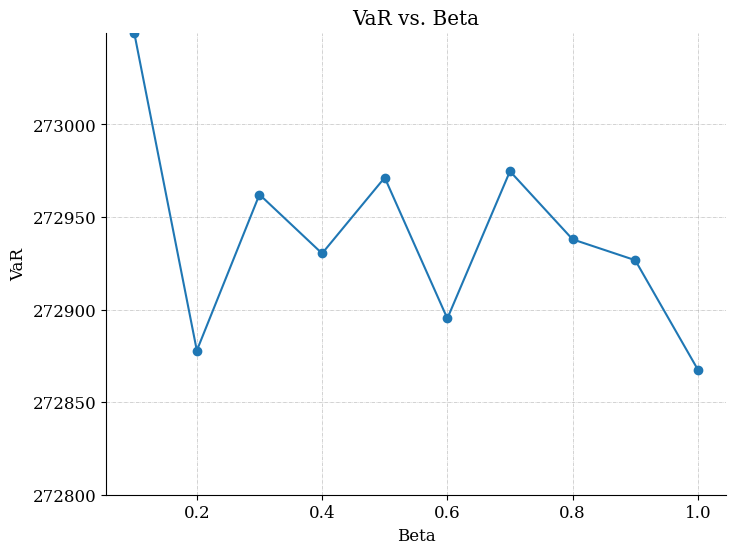

In [42]:
var_values = []
betas = list(results_per_beta_op.keys())
expected_profit = [results_per_beta_op[beta]['Expected Profit'] for beta in betas]
var_values = [results_per_beta_op[beta]['VaR'] for beta in betas]

# Plot VaR vs. beta
plt.figure(figsize=(8, 6))
plt.plot(beta_values[1:] , var_values[1:], marker='o', linestyle='-')
plt.xlabel('Beta')
plt.ylabel('VaR')
plt.title('VaR vs. Beta')
plt.grid(True)
plt.ylim(272800, max(var_values))
plt.show()

In [ ]:
results_per_beta_op, p_DA_values_per_beta_op = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)

betas = list(results_per_beta_op.keys())


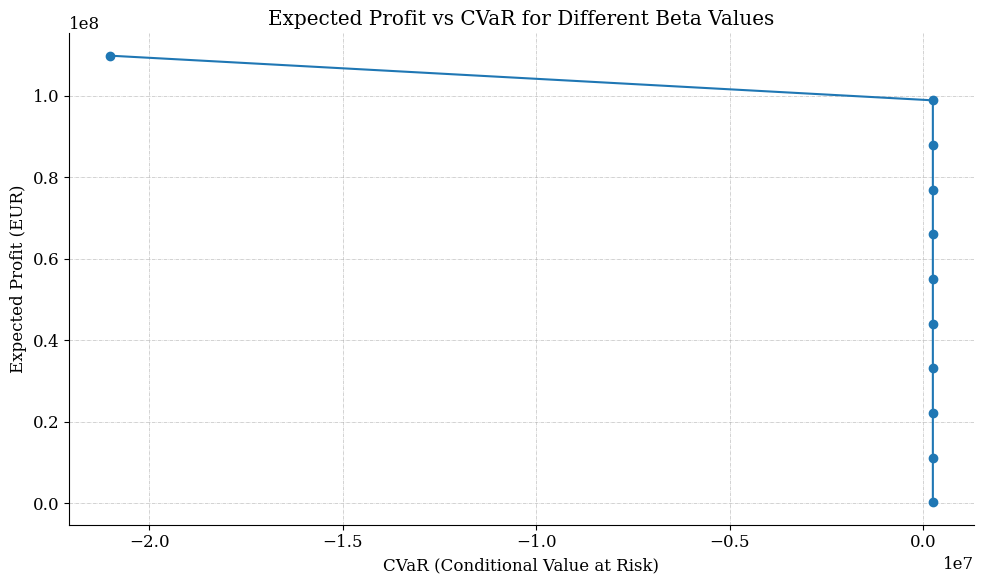

In [26]:
#import matplotlib.pyplot as plt

# Extract beta values and corresponding expected profits
betas = list(results_per_beta_op.keys())
expected_profit = [results_per_beta_op[beta]['Expected Profit'] for beta in beta_values]
cvar_values = [results_per_beta_op[beta]['CVaR'] for beta in beta_values]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cvar_values, expected_profit, marker='o', linestyle='-')
plt.xlabel('CVaR (Conditional Value at Risk)')
plt.ylabel('Expected Profit (EUR)')
plt.title('Expected Profit vs CVaR for Different Beta Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
def cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values):
    results_per_beta = {}
    p_DA_values_per_beta = {}
    
    for beta in beta_values: 
        direction = gb.GRB.MAXIMIZE #Min / Max

        m = gb.Model() # Create a Gurobi model  

        m.setParam('OutputFlag', 0)

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
        delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up") # surplus
        delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down") # deficit
        eta = m.addVars(OMEGA, lb=0, ub=gb.GRB.INFINITY, name="n")  # auxiliary variable for risk-averse term
        zeta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta")  # VaR variable for risk-averse term

        imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I") # imbalance revenue - can be negative

        # binary variables used to control the two-price logic
        y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")
        z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")

        #============= Objective function =============
        # Set objective function
        expected_value = gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
        
        cvar = zeta- (1 / (1 - alpha)) * gb.quicksum(PI * eta[w] for w in range(OMEGA))
        obj = (1 - beta)*expected_value + beta*cvar

        m.setObjective(obj, direction)

        #============= Day-ahead power bid limits ============

        #Upper limit is the nominal wind power
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definitions ===============
        m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta[t,w] == delta_up[t,w] - delta_down[t,w] for t in range(T) for w in range(OMEGA))


        M = 1e6 # big-M constant
        #ensure that only one of the delta directions can be non-zero
        m.addConstrs(delta_up[t,w] <= M * (1 - y[t,w]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(delta_down[t,w] <= M * y[t,w] for t in range(T) for w in range(OMEGA))

        #============= Linearized conditional statements ===============
        #Binary variable constraints
        m.addConstrs(z[0,t,w] <= y[t,w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[1,t,w] <= y[t,w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[2,t,w] <= (1 - y[t,w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
        m.addConstrs(z[3,t,w] <= (1 - y[t,w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        # if system is in a surplus and the imbalance is positive (NOT helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[0,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a deficit and the imbalance is positive (IS helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[1,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a surplus and the imbalance is negative (IS helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[2,t,w] for t in range(T) for w in range(OMEGA))

        # if system is in a deficit and the imbalance is negative (NOT helping the system)
        m.addConstrs(imbalance_revenue[t,w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[3,t,w] for t in range(T) for w in range(OMEGA))

         # Cvar constraint
        m.addConstrs(-gb.quicksum(
            scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]
            for t in range(T)) + zeta - eta[w] <= 0 for w in range(OMEGA))
        m.addConstrs(eta[w] >= 0 for w in range(OMEGA))

        #============= Display and run model =============
        m.update()
        #m.display()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            #initialization
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]' ,'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])
                
                for t in range(T):
                    df.loc[t] = [t, 
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                                scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                                delta[t,scenario].x, 
                                delta_up[t,scenario].x, 
                                delta_down[t,scenario].x, 
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                                imbalance_revenue[t,scenario].x, 
                                scenarios[str(scenario)]['System Balance State'][t]]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

                eta_values = [eta[w].x for w in range(OMEGA)]
                cvar_value = cvar.getValue()
                results['Expected Profit'] = m.objVal
                results['CVaR'] = cvar_value
                results['VaR'] = zeta.x
                p_DA_values = [p_DA[t].x for t in range(T)]

            print('-----------------------------------------------')
            print('Results for beta=%.2f' % beta)
            print('Expected Profit: %.2f EUR' % results['Expected Profit'])
            print('CVaR: %.10f EUR' % results['CVaR'])
            print('VaR: %.2f EUR' % results['VaR'])
            print('Eta values:', eta_values)
            print('-----------------------------------------------')
            print('Day-ahead bids:')
            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            for t in range(T):
                print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

            print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
            print('-----------------------------------------------')
            print('Runtime: %f ms' % (m.Runtime * 1e3))
            for scenario in range(OMEGA):
                for t in range(T):
                    if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
                        print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)
             # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization was not successful.")
    return results_per_beta,p_DA_values_per_beta

results_per_beta_tp, p_DA_values_per_beta_tp = cvr_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values)

-----------------------------------------------
Results for beta=0.00
Expected Profit: 163554.74 EUR
CVaR: 0.0000000000 EUR
VaR: 0.00 EUR
Eta values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,